## Data loading

In [1]:
import numpy as np
import sys
from pathlib import Path

# Add the parent directory of the notebook to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from utils.kl_matrix import create_kl_adjacency
from utils.internal_validation_metrics import manual_silhouette_score, manual_dbi, manual_modularity

In [2]:
import pandas as pd
import pyarrow.parquet as pq
from IPython.display import display
# # Read Parquet with PyArrow, keeping pandas metadata
# table = pq.read_table("../data/videogame_sequences/sequence_dataset.parquet", use_pandas_metadata=True)
# df = table.to_pandas()

from utils.load import load_ctms_dataset
df = load_ctms_dataset("../data/videogame_sequences/sequence_dataset.parquet", stack_ctms=False)
display(df.head(5))

# Robust CTM stacking that unwraps singleton nesting and coerces to float array
def stack_ctm(entry):
    import ast

    e = entry
    # unwrap extra singleton nesting like [[...]] -> [...]
    while isinstance(e, (list, tuple)) and len(e) == 1:
        e = e[0]

    # if stored as a string, try to parse it
    if isinstance(e, str):
        e = ast.literal_eval(e)

    arr = np.array(e, dtype=object)

    # if object dtype, try to build numeric rows
    if arr.dtype == object:
        try:
            rows = [np.asarray(r, dtype=float) for r in arr]
            arr = np.vstack(rows)
        except Exception as exc:
            raise ValueError(f"Cannot convert CTM entry to numeric array: {exc}")

    # handle an extra leading singleton dimension (1,129,129)
    if arr.ndim == 3 and arr.shape[0] == 1 and arr.shape[1:] == (129, 129):
        arr = arr.squeeze(0)

    if arr.shape != (129, 129):
        raise ValueError(f"Unexpected CTM shape {arr.shape}; expected (129,129)")

    return arr.astype(float)

def normalize_global(M: np.ndarray) -> np.ndarray:
    total = M.sum()
    return M / total if total != 0 else M.astype(float)

# Apply conversion + normalization with index-aware errors for easier debugging
ctm_matrices = []
for i, e in enumerate(df["ctm"]):
    try:
        mat = stack_ctm(e)
        mat = normalize_global(mat)
        ctm_matrices.append(mat)
    except Exception as exc:
        raise ValueError(f"Error processing ctm at row {i}: {exc}")

df["ctm_matrix"] = ctm_matrices

# Quick verification
print("Rows:", len(df))
print("Example shape (row 0):", df.loc[0, "ctm_matrix"].shape)
print("Sum of example (row 0):", df.loc[0, "ctm_matrix"].sum())
# Optionally check that every matrix sums to 1 (or 0 if originally all zeros)
sums = df["ctm_matrix"].apply(np.sum)
print("Number of matrices with sum == 1:", (np.isclose(sums, 1.0)).sum())
print("Number of zero-sum matrices:", (sums == 0).sum())

,name,note_sequence,ctm,id,rating,themes,keywords,involved_companies,first_release_year,metadata
0,Star Wars: Rogue Squadron II - Rogue Leader,"[55, 55, 60, 60, 48, 48, 51, 51, 62, 62, 56, 5...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4181,85.4,"[""Action"", ""Science fiction""]","[""space simulation"", ""space combat"", ""robots"",...","[""Activision"", ""Factor 5"", ""LucasArts""]",2001,star wars rogue squadron ii rogue leader actio...
1,Star Wars: Rogue Squadron II - Rogue Leader,"[59, 38, 47, 47, 59, 47, 47, 38, 59, 47, 38, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4181,85.4,"[""Action"", ""Science fiction""]","[""space simulation"", ""space combat"", ""robots"",...","[""Activision"", ""Factor 5"", ""LucasArts""]",2001,star wars rogue squadron ii rogue leader actio...
2,Donkey Kong Jungle Beat,"[45, 64, 61, 57, 64, 61, 57, 45, 57, 64, 61, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1097,67.7,"[""Action""]","[""combat"", ""pig"", ""panda"", ""underwater gamepla...","[""Nintendo EAD Tokyo Software Development Grou...",2004,donkey kong jungle beat action combat pig pand...
3,Donkey Kong Jungle Beat,"[70, 71, 72, 73, 42, 23, 49, 73, 61, 56, 49, 6...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1097,67.7,"[""Action""]","[""combat"", ""pig"", ""panda"", ""underwater gamepla...","[""Nintendo EAD Tokyo Software Development Grou...",2004,donkey kong jungle beat action combat pig pand...
4,Viewtiful Joe,"[33, 33, 75, 81, 33, 36, 36, 36, 38, 38, 59, 3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",341259,0,"[""Action""]",[],"[""Clover Studio"", ""Capcom""]",2004,viewtiful joe action clover studio capcom


Rows: 3320
Example shape (row 0): (129, 129)
Sum of example (row 0): 1.0
Number of matrices with sum == 1: 3320
Number of zero-sum matrices: 0


In [3]:
p = Path("../data") / "ctms_distance_matrix.npy"

if p.exists():
    print("Distance matrix already exists; loading from file.")
    distance_matrix = np.load(p)
else:
    ctms_list = df['ctm_matrix'].tolist()
    distance_matrix = create_kl_adjacency(ctms_list)
    np.save(p, distance_matrix)

Distance matrix already exists; loading from file.


## Spectral clustering

### Distances to similarity

In [4]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def distance_to_local_scaled_similarity(D: np.ndarray, k: int = 15, scale_factor: float = 2.0) -> np.ndarray:
    """
    Robust Self-Tuning Spectral Clustering.
    
    Fixes 'clustered towards 0' by:
    1. Using MEAN distance for sigma (prevents tiny sigma from duplicates).
    2. Adding a scale_factor to widen the Gaussian kernel.
    """
    n = D.shape[0]
    
    # 1. k-NN search
    # Request k+1 because the first neighbor is self (dist=0)
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric='precomputed')
    nbrs.fit(D)
    knn_dists, knn_indices = nbrs.kneighbors(D)
    
    # 2. Calculate ROBUST Sigmas
    # Instead of just the k-th neighbor, use the MEAN of the k neighbors.
    # This prevents 'collapsing' if the first few neighbors are duplicates.
    # scale_factor (e.g. 2.0) ensures the tail of the distribution doesn't vanish too fast.
    sigmas = np.mean(knn_dists[:, 1:], axis=1) * scale_factor
    
    # Safety: prevent division by zero if all neighbors are identical
    avg_global_dist = np.mean(knn_dists[:, 1:]) + 1e-9
    sigmas[sigmas < 1e-9] = avg_global_dist
    
    sim_matrix = np.zeros((n, n))
    
    # 3. Compute Weights
    for i in range(n):
        neighbors = knn_indices[i, 1:]
        
        # Original squared distances
        d_sq = knn_dists[i, 1:] ** 2
        
        # Scaling denominator: sigma_i * sigma_j
        # This is the Zelnik-Manor magic: it adapts to the density of BOTH points.
        sigma_prod = sigmas[i] * sigmas[neighbors]
        
        # Compute Gaussian
        weights = np.exp(-d_sq / sigma_prod)
        
        # Hard check: If weights are still microscopic, clip them to a minimum
        # This ensures the graph doesn't mathematically sever.
        weights[weights < 1e-4] = 1e-4 
        
        sim_matrix[i, neighbors] = weights

    # 4. Symmetrize (Maximum preserves the strongest connection)
    sim_matrix = np.maximum(sim_matrix, sim_matrix.T)
    np.fill_diagonal(sim_matrix, 0)
    
    return sim_matrix

sim_matrix = distance_to_local_scaled_similarity(distance_matrix, k=15, scale_factor=2.0)

### Spectral Embedding + k-Means

In [5]:
import pickle
from pathlib import Path
from scipy.linalg import fractional_matrix_power
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

# File to save/load clustering results
p_clusters = Path("../data/ctms_clusters.pkl")
k_values = range(2, 15)

if p_clusters.exists():
    print("Clustering results already exist; loading from file.")
    with open(p_clusters, "rb") as f:
        results = pickle.load(f)
    labels_all = results['labels_all']
    scores = results['silhouette_scores']
    dbi_scores = results['dbi_scores']
    mod_scores = results['modularity_scores']
    X_norm_all = results.get('X_norm_all', None)  # load if saved
else:
    from scipy.linalg import eigh

    # Compute Laplacian
    D = np.diag(sim_matrix.sum(axis=1))
    D_inv_sqrt = fractional_matrix_power(D, -0.5)
    L_sym = np.eye(sim_matrix.shape[0]) - D_inv_sqrt @ sim_matrix @ D_inv_sqrt

    scores = []
    dbi_scores = []
    mod_scores = []
    labels_all = {}     # store labels for each k
    X_norm_all = {}     # store normalized eigenvectors for each k

    for k in k_values:
        eigvals, eigvecs = eigh(L_sym)
        X = eigvecs[:, :k]
        X_norm = normalize(X, norm='l2', axis=1)
        X_norm_all[k] = X_norm  # save normalized vectors

        labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_norm)
        labels_all[k] = labels

        # silhouette
        sill = manual_silhouette_score(X_norm, labels)
        scores.append(sill)

        # Davies–Bouldin Index (lower is better)
        dbi = manual_dbi(X_norm, labels)
        dbi_scores.append(dbi)

        # modularity
        mod = manual_modularity(sim_matrix, labels)
        mod_scores.append(mod)

    # save results including X_norm_all
    with open(p_clusters, "wb") as f:
        pickle.dump({
            'labels_all': labels_all,
            'silhouette_scores': scores,
            'dbi_scores': dbi_scores,
            'modularity_scores': mod_scores,
            'X_norm_all': X_norm_all
        }, f)

Clustering results already exist; loading from file.


In [6]:
avg_dispersion = []

for k in k_values:
    X_norm = X_norm_all[k]
    labels = labels_all[k]
    dispersion = 0

    for cluster_id in range(k):
        cluster_points = X_norm[labels == cluster_id]  # boolean mask is valid now
        if len(cluster_points) > 1:
            centroid = cluster_points.mean(axis=0)
            dispersion += np.mean(np.linalg.norm(cluster_points - centroid, axis=1))

    dispersion /= k
    avg_dispersion.append(dispersion)

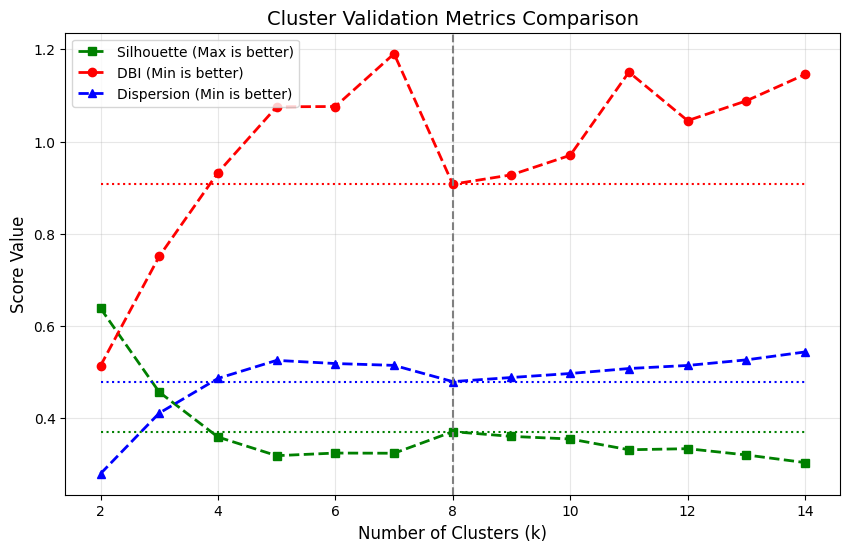

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure
plt.figure(figsize=(10, 6))

# 1. Silhouette (Higher is Better) - Solid Green
plt.plot(k_values, scores, 'g--s', linewidth=2, label='Silhouette (Max is better)')

# 2. DBI (Lower is Better) - Dashed Red
plt.plot(k_values, dbi_scores, 'r--o', linewidth=2, label='DBI (Min is better)')

# 3. Dispersion (Elbow) - Dashed Blue
plt.plot(k_values, avg_dispersion, 'b--^', linewidth=2, label='Dispersion (Min is better)')

plt.legend(loc='best', frameon=True)

# Mark k=8:
try:
    idx_k8 = list(k_values).index(8)
except ValueError:
    # fallback if k_values is not a plain sequence
    idx_k8 = int(np.where(np.array(list(k_values)) == 8)[0][0])

y_sil_k8 = scores[idx_k8]
y_dbi_k8 = dbi_scores[idx_k8]
y_disp_k8 = avg_dispersion[idx_k8]

# Vertical line at k=8
plt.axvline(x=8, color='gray', linestyle='--', linewidth=1.5, label='k = 8')

# Horizontal lines at the three metric values at k=8
plt.hlines(y_sil_k8, xmin=min(k_values), xmax=max(k_values), colors='green', linestyles=':', linewidth=1.5, label=f'Silhouette @k=8 ({y_sil_k8:.3f})')
plt.hlines(y_dbi_k8, xmin=min(k_values), xmax=max(k_values), colors='red', linestyles=':', linewidth=1.5, label=f'DBI @k=8 ({y_dbi_k8:.3f})')
plt.hlines(y_disp_k8, xmin=min(k_values), xmax=max(k_values), colors='blue', linestyles=':', linewidth=1.5, label=f'Dispersion @k=8 ({y_disp_k8:.3f})')

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Score Value', fontsize=12)
plt.title('Cluster Validation Metrics Comparison', fontsize=14)
plt.grid(True, alpha=0.3)

plt.show()

### Pick best $k$

In [8]:
best_k = 8
best_labels = labels_all[best_k]
print("Best k:", best_k)
print(f"Silhouette score for k={best_k}: {manual_silhouette_score(X_norm_all[best_k], best_labels):.4f}")

Best k: 8
Silhouette score for k=8: 0.3710


In [9]:
# Ensure matrices_df exists (build from df if missing)
if 'matrices_df' not in globals():
    if 'ctm_matrix' in df.columns:
        matrices_df = df[['ctm_matrix']].rename(columns={'ctm_matrix': 'ctm'}).copy()
    elif 'ctm' in df.columns:
        matrices_df = df[['ctm']].copy()
    else:
        raise ValueError("Cannot build matrices_df: neither 'ctm_matrix' nor 'ctm' found in df.")
    matrices_df.index.name = 'song_idx'

# Choose labels: prefer best_labels, fall back to other globals if necessary
if 'best_labels' in globals():
    labels = best_labels
elif 'labels' in globals():
    labels = labels
elif 'labels_all' in globals() and 'best_k' in globals():
    labels = labels_all[best_k]
else:
    raise ValueError("No clustering labels found in globals (expected 'best_labels' or 'labels').")

In [10]:
# Align labels with how clustering was stored and write back to the original parquet
if 'labels' in globals():
    labels_array = np.asarray(labels)
elif 'best_k' in globals() and 'labels_all' in globals():
    labels_array = np.asarray(labels_all[best_k])
else:
    raise ValueError("No clustering labels found ('labels' or 'labels_all' with 'best_k').")

# Sanity check
if len(labels_array) != len(df):
    raise ValueError(f"Length mismatch: labels ({len(labels_array)}) vs df ({len(df)})")

# Add cluster column to the dataframe
df['cluster_number'] = labels_array.astype(int)

# Write the parquet with the new column
p_path = Path("../data") / "sequence_dataset_clusters.parquet"

# Module-level import at top of cell
import pyarrow as pa

# PyArrow cannot directly convert 2D numpy arrays in a pandas column.
# Convert the 'ctm_matrix' column to nested Python lists (serializable) or drop it
# from the table if you don't want to save it.
df_to_save = df.copy()

if 'ctm_matrix' in df_to_save.columns:
    # Convert numpy arrays (129x129) to nested lists so PyArrow can handle them.
    df_to_save['ctm_matrix_serialized'] = df_to_save['ctm_matrix'].apply(
        lambda m: m.tolist() if isinstance(m, np.ndarray) else (m if isinstance(m, list) else None)
    )
    # It's safer to drop the original numpy-array column to avoid Arrow errors.
    df_to_save = df_to_save.drop(columns=['ctm_matrix'])

# Build PyArrow table and write parquet (pq was imported earlier in the notebook)
table = pa.Table.from_pandas(df_to_save, preserve_index=False)
pq.write_table(table, p_path)
print(f"Saved parquet with new column 'cluster_number' to {p_path}")

# Print representative titles (or indices if 'title' missing) per cluster
num_clusters = int(labels_array.max()) + 1
for cluster_id in range(num_clusters):
    mask = df['cluster_number'] == cluster_id
    n = int(mask.sum())
    if 'title' in df.columns:
        items = df.loc[mask, 'title'].head(10).values
    else:
        items = df.index[mask][:10].tolist()
    print(f"\nCluster {cluster_id+1} (n={n}):")
    print(items)

# Visualize again head of parquet with new cluster_number column
display(df.head(1))

Saved parquet with new column 'cluster_number' to ..\data\sequence_dataset_clusters.parquet

Cluster 1 (n=494):
[4, 12, 13, 18, 19, 20, 29, 32, 39, 41]

Cluster 2 (n=432):
[6, 17, 24, 63, 74, 77, 78, 79, 94, 107]

Cluster 3 (n=435):
[8, 9, 22, 25, 35, 40, 57, 66, 67, 69]

Cluster 4 (n=500):
[3, 7, 42, 62, 80, 84, 91, 95, 105, 108]

Cluster 5 (n=428):
[14, 15, 16, 23, 27, 31, 37, 38, 43, 44]

Cluster 6 (n=585):
[0, 1, 2, 5, 10, 11, 21, 26, 28, 30]

Cluster 7 (n=206):
[47, 49, 75, 93, 131, 145, 152, 213, 218, 222]

Cluster 8 (n=240):
[34, 36, 46, 68, 76, 81, 83, 104, 118, 123]


,name,note_sequence,ctm,id,rating,themes,keywords,involved_companies,first_release_year,metadata,ctm_matrix,cluster_number
0,Star Wars: Rogue Squadron II - Rogue Leader,"[55, 55, 60, 60, 48, 48, 51, 51, 62, 62, 56, 5...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4181,85.4,"[""Action"", ""Science fiction""]","[""space simulation"", ""space combat"", ""robots"",...","[""Activision"", ""Factor 5"", ""LucasArts""]",2001,star wars rogue squadron ii rogue leader actio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5


In [11]:
from typing import Dict, List, Optional, Union
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import logging
from loguru import logger

def tfidf_cluster_summary(
    df: pd.DataFrame,
    save_path: Optional[str] = None,
    k: int = 50,
    ngram_range=(1, 2),
    min_df: int = 1,
    max_df: float = 0.8,
    scoring: str = "distinctiveness",  # "distinctiveness" or "tfidf"
) -> Dict[Union[int, str], List[str]]:
    """
    Compute top-k keywords per cluster from the 'metadata' column.

    uses a global TF-IDF vectorizer fitted on all documents, then computes
    mean TF-IDF per cluster to find distinctive terms.

    Args:
        df: DataFrame containing 'cluster_label' and 'metadata' (or 'metadata_combined').
        k: Top-k terms to return per cluster.
        ngram_range: N-gram range for TF-IDF.
        min_df: Minimum doc frequency (absolute).
        max_df: Max document frequency ratio.
        scoring: 'distinctiveness' (default) or 'tfidf' (cluster mean TF-IDF).
    """

    if "cluster_label" not in df.columns:
        raise ValueError("DataFrame must contain 'cluster_label'.")

    if "metadata" in df.columns:
        text_col = "metadata"
    elif "metadata_combined" in df.columns:
        text_col = "metadata_combined"
    else:
        raise ValueError("DataFrame must contain 'metadata' or 'metadata_combined'.")

    all_texts = df[text_col].fillna("").astype(str).tolist()
    if len(all_texts) == 0 or all(t.strip() == "" for t in all_texts):
        return {}

    n_docs = len(all_texts)

    # Ensure max_df is consistent with min_df for small n_docs
    if isinstance(max_df, float) and max_df < 1.0:
        min_allowed_max_df = min_df / n_docs
        if max_df < min_allowed_max_df:
            max_df = min_allowed_max_df

    vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
    )

    try:
        tfidf_all = vectorizer.fit_transform(all_texts)
    except ValueError as e:
        vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words=None,
            ngram_range=ngram_range,
            min_df=1,
            max_df=1.0,
        )
        tfidf_all = vectorizer.fit_transform(all_texts)

    if tfidf_all.shape[1] == 0:
        return {}

    feature_names = np.array(vectorizer.get_feature_names_out())
    global_mean = np.asarray(tfidf_all.mean(axis=0)).ravel()

    results: Dict[Union[int, str], List[str]] = {}
    clusters = df["cluster_label"].unique()

    for cluster in clusters:
        idx = np.where(df["cluster_label"].values == cluster)[0]
        if len(idx) == 0:
            results[cluster] = []
            continue

        tfidf_cluster = tfidf_all[idx, :]
        if tfidf_cluster.shape[0] == 0:
            results[cluster] = []
            continue

        cluster_mean = np.asarray(tfidf_cluster.mean(axis=0)).ravel()

        if scoring == "tfidf":
            scores = cluster_mean
        else:
            scores = cluster_mean - global_mean

        if scores.size == 0:
            results[cluster] = []
            continue

        top_idx = np.argsort(scores)[::-1][:k]
        results[cluster] = feature_names[top_idx].tolist()

    # JSON can't handle np.int64 keys
    results = {int(c): v for c, v in results.items()}

    if save_path:
        logger.info(f"Saving TF-IDF cluster summary to {save_path}")
        with open(save_path, "w") as f:
            json.dump(results, f, indent=4)

    return results




# Run TF-IDF cluster summary on the dataframe with 'cluster_number'
tfidf_keywords = tfidf_cluster_summary(
    df=df.rename(columns={"cluster_number": "cluster_label"}),
    save_path="ctms_tfidf_cluster_summary.json",
    k=50,
)

2025-12-04 16:31:01.902 | INFO     | __main__:tfidf_cluster_summary:111 - Saving TF-IDF cluster summary to ctms_tfidf_cluster_summary.json


In [ ]:
raise ValueError("Stop here for debugging TF-IDF cluster summary.")

In [ ]:
import sys
# This forces the kernel to look in the local user site-packages where fa2_modified is located
sys.path.append('/home/jyanes/.local/lib/python3.8/site-packages')

# Now try the import again
from fa2_modified import ForceAtlas2

No cython detected.  Install cython and compile the fa2util module for a 10-100x speed boost.


100%|██████████| 2000/2000 [21:37<00:00,  1.54it/s]


BarnesHut Approximation  took  131.80  seconds
Repulsion forces  took  1058.24  seconds
Gravitational forces  took  4.13  seconds
Attraction forces  took  89.61  seconds
AdjustSpeedAndApplyForces step  took  11.62  seconds


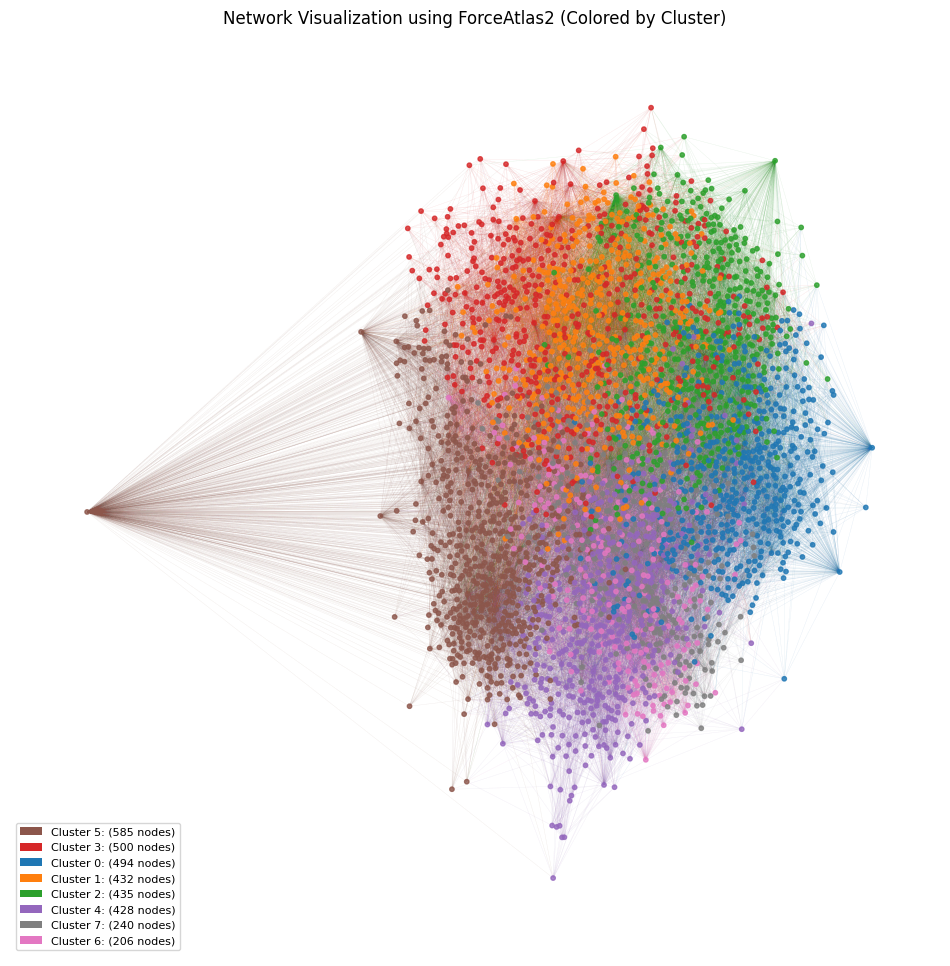

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import cm
from collections import Counter

def visualize_graph(sim_matrix, labels, filename):

    cluster_labels = labels.tolist()
    cluster_sizes = dict(Counter(cluster_labels))

    tab10 = [
        '#1f77b4',  
        '#ff7f0e',  
        '#2ca02c',  
        '#d62728',  
        '#9467bd',  
        '#8c564b',  
        '#e377c2',  
        '#7f7f7f',  
        '#bcbd22',  
        '#17becf'   
    ]

    # add more colors if more clusters are expected
    # cluster_colors = ['#ff1493', '#39FF14', '#0088ff', '#FFA500', '#000000', '#BC13FE']
    cluster_colors = tab10

    node_colors = [cluster_colors[cluster_labels[i]] for i in range(sim_matrix.shape[0])]

    # Adjust node size based on community size (isolated nodes are larger)
    # node_sizes = [
    #     50 if louvain_partition[node] == -1 else 10 + community_sizes[louvain_partition[node]] ** 0.5
    #     for node in G_undirected.nodes()
    # ]

    G = nx.Graph()

    for i in range(len(sim_matrix)):  #add nodes
        G.add_node(i) 

    node_sizes = [
        10 for _ in G.nodes()
    ]

    edges_toshow = {}

    for i in range(len(sim_matrix)):
        for j in range(i + 1, len(sim_matrix)):

            clr = cluster_colors[cluster_labels[i]]

            if sim_matrix[i, j] > 0:
                if clr not in edges_toshow:
                    edges_toshow[clr] = []
                
                edges_toshow[clr].append((i,j))
                
                edges_toshow[clr].append((i,j))
                G.add_edge(i, j, weight=sim_matrix[i, j])


    # Step 3: Use the ForceAtlas2 algorithm to compute node layout
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=True,  # Dissuade hubs
        linLogMode=False,  # Use linear distances
        adjustSizes=False,  # Prevent overlap
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1,
        scalingRatio=75,
        strongGravityMode=False,
        gravity=3,
        verbose=True
    )

    G_undirected = G
    positions = forceatlas2.forceatlas2_networkx_layout(G_undirected, pos=None, iterations=2000)

    # Draw the network graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(
        G_undirected, 
        pos=positions, 
        node_color=node_colors, 
        node_size=[
            node_sizes[i]
            for i, node in enumerate(G_undirected.nodes())
        ], 
        alpha=0.8,
    )

    for c in list(edges_toshow.keys()):
        nx.draw_networkx_edges(
            G_undirected, 
            edgelist=edges_toshow[c],
            pos=positions, 
            edge_color=c, 
            width=0.3,
            alpha=[
                0.05 
                for _ in edges_toshow[c]
            ]
        )

    communities = [i for i in range(6)]

    plt.title("Network Visualization using ForceAtlas2 (Colored by Cluster)")
    legend_elements = [
        # Replace 16 with community sizes
        Patch(facecolor=cluster_colors[community], label=f"Cluster {community}: ({cluster_sizes[community]} nodes)")
        for community in list(cluster_sizes.keys())
    ]
    # legend_elements.append(Patch(facecolor=(0.7, 0.7, 0.7), label="Other Communities"))
    plt.legend(handles=legend_elements, loc="lower left", fontsize=8)

    plt.axis('off')  # Hide axes
    # plt.show()
    plt.savefig(f"{filename}", dpi=300, bbox_inches="tight")

# Use the function to visualize and save the graph
visualize_graph(sim_matrix, labels_all[best_k], filename="CTM_based_graph_visualization.png")